Import all necessary libraries to use BERT

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

import pandas as pd

tf.get_logger().setLevel('ERROR')

We now need to set up the dataset so that it can be used with a TensorFlow model (i.e. BERT)

In [ ]:
with open("/Users/alejc/onedrive/Desktop/CS159/nlp-final-project/data/liar.data/train.tsv", "r", encoding="utf-8") as infile, open("/Users/alejc/onedrive/Desktop/CS159/nlp-final-project/data/liar.data/traincleaned.tsv", "w", encoding="utf-8") as outfile:
    for line in infile:
        # Remove problematic quotes and extra line breaks
        clean_line = line.replace('"', '').replace('\n', '').replace('\r', '')
        outfile.write(clean_line + "\n")


In [ ]:
def parse_tsv_line(line):
    # Define the column types
    column_defaults = [
    '',  # JSON file name
    '',  # Boolean flag as string
    '',  # Statement
    '',  # Topic
    '',  # Speaker
    '',  # Speaker's title
    '',  # State
    '',  # Party
    0,   # Truth count 1
    0,   # Truth count 2
    0,   # Truth count 3
    0,   # Truth count 4
    0,   # Truth count 5
    ''   # Source
]
    # Decode the line into individual columns
    columns = tf.io.decode_csv(line, record_defaults=column_defaults, field_delim='\t', use_quote_delim=True)
    # Separate features and label
    # Separate features and label (assuming no label for now)
    string_features = columns[2:8] + columns[-1:]  # Select all string columns
    numeric_features = columns[8:-1]  # Select integer columns (truth counts)

    # Combine string and numeric features into a single dictionary
    features = {
        "string_features": string_features,
        "numeric_features": tf.stack(numeric_features)
    }

    # If there's a label column, define it here; otherwise, return features only
    label = columns[1]  # Replace with actual label column index if applicable
    return features, label

def create_tsv_dataset(file_path, batch_size=32):
    # Load the file
    dataset = tf.data.TextLineDataset(file_path)
    # Skip the header if the file has one
    # dataset = dataset.skip(1) <- curret file doesn't have a header but if it did we could skip the top row
    # Parse each line
    dataset = dataset.map(parse_tsv_line)
    # Shuffle, batch, and prefetch for performance
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset



In [ ]:
# Path to your .tsv file
file_path = "/Users/alejc/onedrive/Desktop/CS159/nlp-final-project/data/liar.data/traincleaned.tsv"

# Create the dataset
batch_size = 32

dataset = create_tsv_dataset(file_path, batch_size)

# Iterate through the dataset
for features, labels in dataset.take(1):
    print("Features:", features)
    print("Labels:", labels)


Utilize pandas to get some preliminary data analysis

In [ ]:
import pandas as pd

# Load the TSV file into a pandas DataFrame
file_path = "/Users/alejc/onedrive/Desktop/CS159/nlp-final-project/data/liar.data/train.tsv"
column_names = [
    "json_file", "label", "statement", "topic", "speaker", "speaker_title",
    "state", "party", "barely_true", "false", "half_true",
    "mostly_true", "pants_on_fire", "source"
]
df = pd.read_csv(file_path, sep='\t', names=column_names)

# Find the most common party
most_common_label = df['party'].value_counts().idxmax()
print("Most common label:", most_common_label)


In [ ]:
# Group by label and compute the mean of truth_count_5
average_truth_count_5_per_label = df.groupby('state')['pants_on_fire'].mean()
print("Average Truth Count 5 per label:")
print(average_truth_count_5_per_label)


In [ ]:
# Group by label and state, and count occurrences
state_counts = df.groupby(['label', 'state']).size().reset_index(name='count')

# For each label, find the top 5 states
top_5_states_by_label = state_counts.groupby('label').apply(
    lambda group: group.nlargest(5, 'count')
).reset_index(drop=True)

print("Top 5 states by label:")
print(top_5_states_by_label)

Preprocess Data For BERT

In [ ]:
import pandas as pd

# Read train data
train = pd.read_csv("/Users/alejc/onedrive/Desktop/CS159/nlp-final-project/data/liar.data/train.tsv", sep='\t', header=None)

# Drop columns by index
columns_to_remove = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]  # Indices of the columns to remove
train = train.drop(columns=columns_to_remove)

# assign numbers to truth label
label_column = train.columns[0]  
# Define the mapping of strings to numbers
label_mapping = {
    'true': 0,
    'mostly-true': 1,
    'half-true': 2,
    'barely-true': 3,
    'false': 4,
    'pants-fire': 5
}
train[label_column] = train[label_column].map(label_mapping)

# Save the updated DataFrame back to a TSV file
output_path = 'train_update.tsv'  # Replace with your desired output file path
train.to_csv(output_path, sep='\t', index=False)

In [2]:
import pandas as pd
# read test data
test = pd.read_csv("/Users/alejc/onedrive/Desktop/CS159/nlp-final-project/data/liar.data/valid.tsv", sep='\t', header=None)

# Drop columns by index
columns_to_remove = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]  # Indices of the columns to remove
test = test.drop(columns=columns_to_remove)

# assign numbers to truth label
label_column = test.columns[0]  
# Define the mapping of strings to numbers
label_mapping = {
    'true': 0,
    'mostly-true': 1,
    'half-true': 2,
    'barely-true': 3,
    'false': 4,
    'pants-fire': 5
}
test[label_column] =  test[label_column].map(label_mapping)

# Save the updated DataFrame back to a TSV file
output_path = 'valid_update.tsv'  # Replace with your desired output file path
test.to_csv(output_path, sep='\t', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

train = pd.read_csv("/Users/alejc/onedrive/Desktop/CS159/nlp-final-project/data/liar.data/train_update.tsv", sep='\t', header=None)
test = pd.read_csv("/Users/alejc/onedrive/Desktop/CS159/nlp-final-project/data/liar.data/test_update.tsv", sep='\t', header=None)


# Create dataframes for train 
train_bert_df = pd.DataFrame({
    'id': range(len(train)),
    'label': train[0],
    'alpha': ['q']*train.shape[0],
    'text': train[1].replace(r'\n', ' ', regex=True).str.lower()
})

test_bert_df = pd.DataFrame({
    'id': range(len(test)),
    'text': test[1].replace(r'\n', ' ', regex=True).str.lower()
})

train_bert_df.head()

train_bert_df.to_csv('bert_df_train.tsv', sep='\t', index=False, header=False)
test_bert_df.to_csv('bert_df_test.tsv', sep='\t', index=False, header=False)


Tokenize with BertTokenizer

In [ ]:
from transformers import BertTokenizer
import pandas as pd
import tensorflow as tf

file_path = "C:\\Users\\alejc\\OneDrive\\Desktop\\CS159\\nlp-final-project\\data\\liar.data\\test_update.tsv"
vocab_file = "C:\\Users\\alejc\\OneDrive\\Desktop\\CS159\\nlp-final-project\\code\\BERT\\vocab.txt"

# Load the BERT tokenizer
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=True)

# Step 1: Load the TSV file
data = pd.read_csv(file_path, sep="\t", header=None, names=["label", "sentence"])

# Step 2: Extract sentences and labels
labels = data["label"].tolist()
sentences = data["sentence"].tolist()

# Step 3: Tokenize sentences
max_length = 128  # Adjust max length for BERT input
tokenized_inputs = tokenizer(
    sentences,
    max_length=max_length,
    padding="max_length",
    truncation=True,
    return_tensors="tf"  # Use TensorFlow tensors
)

# Extract token IDs and attention masks
input_ids = tokenized_inputs["input_ids"]
attention_masks = tokenized_inputs["attention_mask"]

# Step 4: Convert labels to TensorFlow tensors
labels = tf.convert_to_tensor(labels, dtype=tf.int32)

# Step 5: Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": input_ids, "attention_mask": attention_masks},
    labels
))

# Step 6: Prepare dataset for training
batch_size = 32
dataset = dataset.shuffle(len(sentences)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Step 7: Save preprocessed data (Optional)
output_path = "C:\\Users\\alejc\\OneDrive\\Desktop\\CS159\\nlp-final-project\\data\\preprocessed_test_dataset"
tf.data.experimental.save(dataset, output_path)

print("Data preprocessing complete. Dataset is ready for BERT.")


Load Pretrained BERT model

In [27]:
import torch
from transformers import BertTokenizer
import pandas as pd
import tensorflow as tf

test_file_path = "C:\\Users\\alejc\\OneDrive\\Desktop\\CS159\\nlp-final-project\\data\\liar.data\\test_update.tsv"
train_file_path = "C:\\Users\\alejc\\OneDrive\\Desktop\\CS159\\nlp-final-project\\data\\liar.data\\train_update.tsv"
valid_file_path = "C:\\Users\\alejc\\OneDrive\\Desktop\\CS159\\nlp-final-project\\data\\liar.data\\valid_update.tsv"
vocab_file = "C:\\Users\\alejc\\OneDrive\\Desktop\\CS159\\nlp-final-project\\code\\BERT\\vocab.txt"



# Load the BERT tokenizer
tokenizer = BertTokenizer(vocab_file=vocab_file, do_lower_case=True)

# Step 1: Load the TSV file
test_data = pd.read_csv(test_file_path, sep="\t", header=None, names=["label", "sentence"])
train_data = pd.read_csv(train_file_path, sep="\t", header=None, names=["label", "sentence"])
valid_data = pd.read_csv(valid_file_path, sep="\t", header=None, names=["label", "sentence"])


# Step 2: Extract sentences and labels
test_labels = test_data["label"].tolist()
test_sentences = test_data["sentence"].tolist()

train_labels = train_data["label"].tolist()
train_sentences = train_data["sentence"].tolist()

val_labels = valid_data["label"].tolist()
val_sentences = valid_data["sentence"].tolist()

def tokenize_sentences(sentences, labels, max_length=128):
    inputs = tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs['labels'] = torch.tensor(labels, dtype=torch.long)
    return inputs

train_inputs = tokenize_sentences(train_sentences, train_labels)
val_inputs = tokenize_sentences(val_sentences, val_labels)
test_inputs = tokenize_sentences(test_sentences, test_labels)

print(test_inputs)

{'input_ids': tensor([[ 101, 2311, 1037,  ...,    0,    0,    0],
        [ 101, 5273, 2003,  ...,    0,    0,    0],
        [ 101, 2758, 2198,  ...,    0,    0,    0],
        ...,
        [ 101, 1999, 1996,  ...,    0,    0,    0],
        [ 101, 2758, 2019,  ...,    0,    0,    0],
        [ 101, 2758, 1996,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([0, 1, 1,  ..., 4, 4, 1])}


In [28]:
from torch import device
from transformers import BertForSequenceClassification

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
# model = model.to(device)


In [50]:
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_inputs['labels'])
test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_inputs['labels'])
val_dataset = TensorDataset(val_inputs['input_ids'], val_inputs['attention_mask'], val_inputs['labels'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Im trying to run the below code in terminal to get the classifier to work... its not working :(

In [51]:
from transformers import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset
import torch

# Move model to device
model_name = "prajjwal1/bert-tiny"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=6) 
model = model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

epochs = 5  # Keep this small initially for testing
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    print("this is current epoch: " + str(epoch))

    batch_counter = 0
    for batch in train_loader:
        batch_counter += 1
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        print("this is current batch: " + str(batch_counter))


    print(f"Epoch {epoch + 1} | Training Loss: {total_train_loss / len(train_loader)}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


this is current epoch: 0
this is current batch: 1
this is current batch: 2
this is current batch: 3
this is current batch: 4
this is current batch: 5
this is current batch: 6
this is current batch: 7
this is current batch: 8
this is current batch: 9
this is current batch: 10
this is current batch: 11
this is current batch: 12
this is current batch: 13
this is current batch: 14
this is current batch: 15
this is current batch: 16
this is current batch: 17
this is current batch: 18
this is current batch: 19
this is current batch: 20
this is current batch: 21
this is current batch: 22
this is current batch: 23
this is current batch: 24
this is current batch: 25
this is current batch: 26
this is current batch: 27
this is current batch: 28
this is current batch: 29
this is current batch: 30
this is current batch: 31
this is current batch: 32
this is current batch: 33
this is current batch: 34
this is current batch: 35
this is current batch: 36
this is current batch: 37
this is current batch:

In [52]:
model.eval()  # Set model to evaluation mode
total_val_loss = 0
correct_predictions = 0
total_samples = 0

with torch.no_grad():  # Disable gradient computation for validation
    for batch in val_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        total_val_loss += outputs.loss.item()
        
        # Calculate accuracy
        predictions = torch.argmax(logits, axis=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)

# Calculate average loss and accuracy
avg_val_loss = total_val_loss / len(val_loader)
val_accuracy = correct_predictions / total_samples

print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")


Validation Loss: 1.6912, Validation Accuracy: 0.2553


Loss and Accuracy across Batches

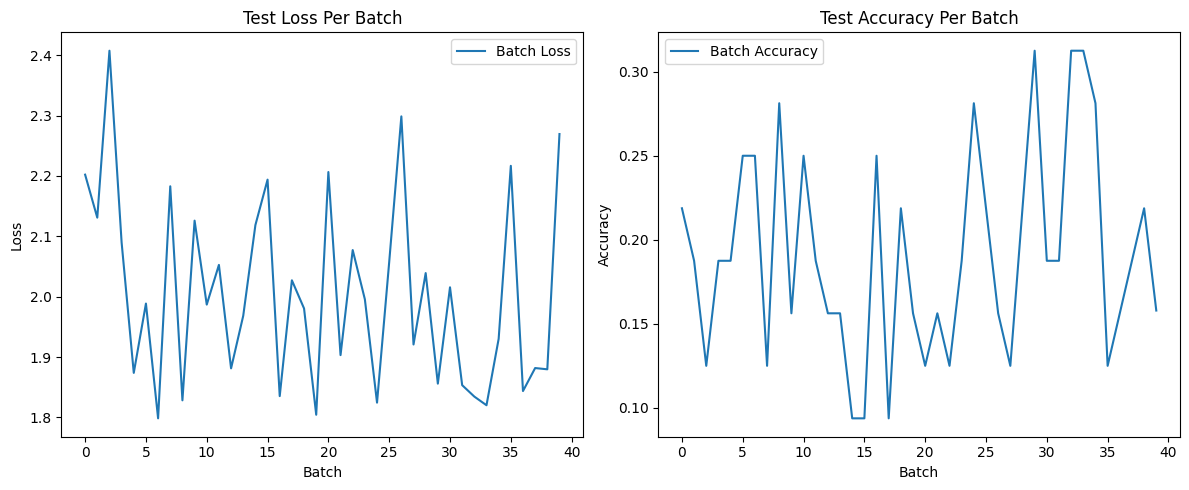

In [53]:
import matplotlib.pyplot as plt

model.eval()  # Set model to evaluation mode

batch_losses = []
batch_accuracies = []

with torch.no_grad():  # Disable gradient computation for efficiency
    for batch in test_loader:  # Assume test_loader is set up
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss.item()
        batch_losses.append(loss)

        # Calculate accuracy for the batch
        predictions = torch.argmax(logits, dim=1)
        batch_accuracy = (predictions == labels).sum().item() / labels.size(0)
        batch_accuracies.append(batch_accuracy)

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(batch_losses, label="Batch Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Test Loss Per Batch")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(batch_accuracies, label="Batch Accuracy")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Per Batch")
plt.legend()

plt.tight_layout()
plt.show()


Generate Confusion Matrix

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (4).

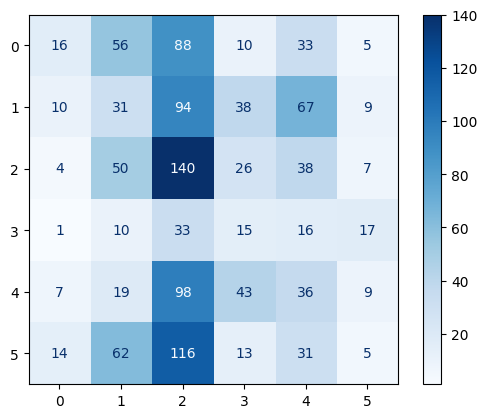

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["class_0", "class_1", ..., "class_5"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
